### Deep Diving Time Confound
Confused about this result, particularly middle component
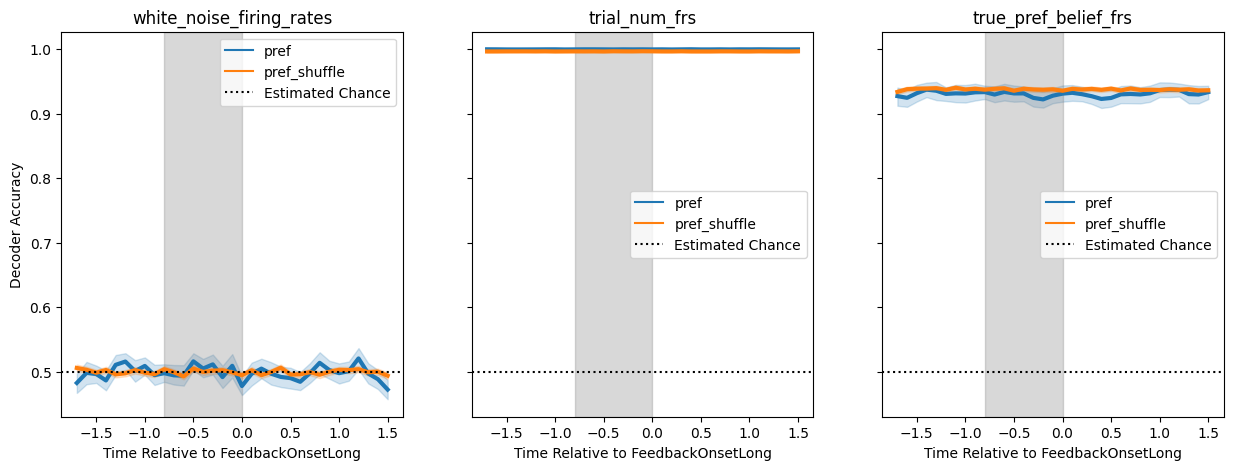

See if we can simplify setup and debug a bit, just look at one session, with trial number as firing rates, an run decoding

### Imports

In [3]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.pseudo_classifier_utils as pseudo_classifier_utils
import utils.classifier_utils as classifier_utils

import utils.io_utils as io_utils
import utils.behavioral_utils as behavioral_utils

from matplotlib import pyplot as plt
import matplotlib
import utils.spike_utils as spike_utils
import utils.subspace_utils as subspace_utils
from utils.session_data import SessionData
from constants.behavioral_constants import *
from constants.decoding_constants import *
import seaborn as sns
from scripts.pseudo_decoding.single_selected_feature_configs import *
import scipy
import argparse
import copy

from models.trainer import Trainer
from models.model_wrapper import ModelWrapper, ModelWrapperLinearRegression
from models.multinomial_logistic_regressor import NormedDropoutMultinomialLogisticRegressor
from trial_splitters.condition_trial_splitter import ConditionTrialSplitter 
from sklearn.linear_model import LogisticRegression


### Constants for the notebook

In [4]:
subject = "SA"
session = "20180802"

pre_interval = 1800
post_interval = 1500
event = "FeedbackOnset"
interval_size = 100

### Load behavioral data for one session, examine behavioral data
Just load Sam, 20180802 first and see

In [5]:
beh = behavioral_utils.get_valid_belief_beh_for_sub_sess(subject, session)

What's the number of blocks per rule in this session

In [6]:
beh.groupby("CurrentRule").BlockNumber.nunique()

CurrentRule
CIRCLE      6
CYAN        6
ESCHER      1
GREEN       6
MAGENTA     3
POLKADOT    4
RIPPLE      4
SQUARE      5
STAR        2
SWIRL       4
TRIANGLE    7
YELLOW      5
Name: BlockNumber, dtype: int64

Seems like a lot of blocks of TRIANGLE, how are the trials where TRIANGLE is preferred distributed across the session?

Text(0.5, 0, 'Trial Number')

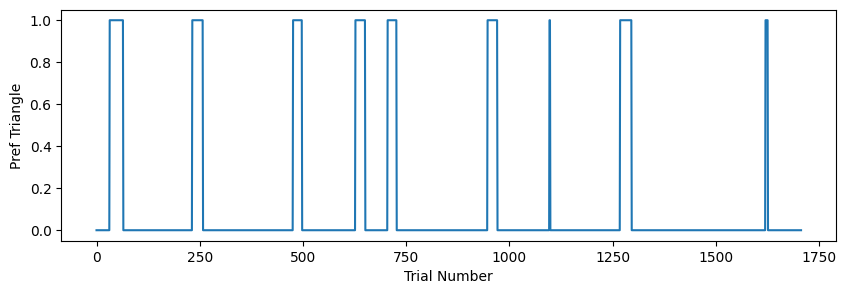

In [7]:
pref_triangle = beh.PreferredBelief.apply(lambda x: 1 if x == "TRIANGLE" else 0)
# consider using the following instead
# pref_triangle = (beh.PreferredBelief == 'TRIANGLE').astype(int)
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(pref_triangle)
ax.set_ylabel("Pref Triangle")
ax.set_xlabel("Trial Number")

### Now load the firing rates, replace with trial number

In [8]:
spikes_path = io_utils.SESS_SPIKES_PATH.format(
    sub=subject,
    sess_name=session, 
    fr_type="firing_rates",
    pre_interval=pre_interval, 
    event=event, 
    post_interval=post_interval, 
    interval_size=interval_size,
)
frs = pd.read_pickle(spikes_path)

In [9]:
frs

,TrialNumber,UnitID,TimeBins,SpikeCounts,FiringRate
0,0,0,0.0,0.0,1.308107
1,0,0,0.1,0.0,6.553153
2,0,0,0.2,2.0,16.406473
3,0,0,0.3,3.0,22.726984
4,0,0,0.4,2.0,21.158603
...,...,...,...,...,...
2654977,1749,45,2.8,0.0,0.539911
2654978,1749,45,2.9,0.0,2.419714
2654979,1749,45,3.0,1.0,3.989435
2654980,1749,45,3.1,0.0,2.421053


In [10]:
trial_num_frs = spike_utils.trial_num_as_frs(frs)

In [11]:
trial_num_frs

,TrialNumber,UnitID,TimeBins,SpikeCounts,FiringRate
0,0,0,0.0,0.0,0
1,0,0,0.1,0.0,0
2,0,0,0.2,2.0,0
3,0,0,0.3,3.0,0
4,0,0,0.4,2.0,0
...,...,...,...,...,...
2654977,1749,45,2.8,0.0,1749
2654978,1749,45,2.9,0.0,1749
2654979,1749,45,3.0,1.0,1749
2654980,1749,45,3.1,0.0,1749


### Set up a decoding run: 

In [12]:
pref_beh = behavioral_utils.get_chosen_preferred_single("TRIANGLE", beh)
pref_beh = behavioral_utils.balance_trials_by_condition(pref_beh, ["Choice"])

/src/wcst_decode/utils/behavioral_utils.py:756: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chose_feat_pref["Choice"] = feat
/src/wcst_decode/utils/behavioral_utils.py:762: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chose_other["Choice"] = "other"


Text(0.5, 0, 'Trial Number')

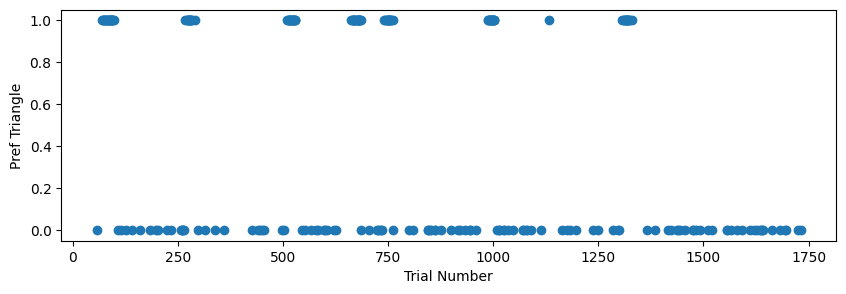

In [13]:
pref_triangle = pref_beh.PreferredBelief.apply(lambda x: 1 if x == "TRIANGLE" else 0)
fig, ax = plt.subplots(figsize=(10, 3))
ax.scatter(pref_beh.TrialNumber, pref_triangle)
ax.set_ylabel("Pref Triangle")
ax.set_xlabel("Trial Number")

In [14]:
trial_num_frs = trial_num_frs.rename(columns={"FiringRate": "Value"})
splitter = ConditionTrialSplitter(pref_beh, "Choice", test_ratio=0.2)
session_data = SessionData(session, pref_beh, trial_num_frs, splitter)
splits = session_data.pre_generate_splits(8)
sess_datas = pd.Series([session_data])

### Decode

In [16]:
classes = ["TRIANGLE", "other"]
num_neurons = sess_datas.apply(lambda x: x.get_num_neurons()).sum()
init_params = {"n_inputs": num_neurons, "p_dropout": 0.5, "n_classes": len(classes)}
# create a trainer object
trainer = Trainer(learning_rate=0.05, max_iter=500, batch_size=1000)
# create a wrapper for the decoder
model = ModelWrapper(NormedDropoutMultinomialLogisticRegressor, init_params, trainer, classes)

# calculate time bins (in seconds)
# less time intervals
post_interval = 0
# time_bins = np.arange(0, (post_interval + pre_interval) / 1000, interval_size / 1000)
time_bins = [0]
train_accs, test_accs, shuffled_accs, models = pseudo_classifier_utils.evaluate_classifiers_by_time_bins(
    model, sess_datas, time_bins, NUM_SPLITS, NUM_TRAIN_PER_COND, NUM_TEST_PER_COND
)

cuda
Working on bin 0
Fitting model
Fitting model
Fitting model
Fitting model
Fitting model
Fitting model
Fitting model
Fitting model


(0.5, 1.0)

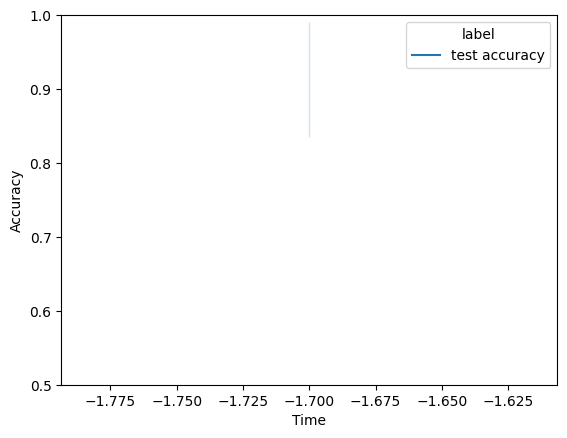

In [17]:
fig, ax = plt.subplots()
visualization_utils.plot_accs_seaborn([test_accs], ["test accuracy"], pre_interval, interval_size, ax)
ax.set_ylim([0.5, 1])

### What about just trial number to choice?
- suspect maybe it's the balancing of trials that might cause high decodability to occur by chance
- try to run re-balancing a bunch of times, plot dist of accuracies
It doesn't seem like such a high accuracy can be purely explained by balancing

In [5]:

scores = []
for i in range(50):
    pref_beh = behavioral_utils.get_chosen_preferred_single("TRIANGLE", beh)
    pref_beh = behavioral_utils.balance_trials_by_condition(pref_beh, ["Choice"])
    X = pref_beh.TrialNumber.values.reshape(-1, 1)
    y = pref_beh.Choice
    clf = LogisticRegression().fit(X, y)
    score = clf.score(X, y)
    scores.append(score)

/src/wcst_decode/utils/behavioral_utils.py:756: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chose_feat_pref["Choice"] = feat
/src/wcst_decode/utils/behavioral_utils.py:762: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chose_other["Choice"] = "other"
/src/wcst_decode/utils/behavioral_utils.py:756: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

(array([ 3.,  4.,  1.,  3.,  0.,  8., 12., 12.,  5.,  2.]),
 array([0.57826087, 0.59217391, 0.60608696, 0.62      , 0.63391304,
        0.64782609, 0.66173913, 0.67565217, 0.68956522, 0.70347826,
        0.7173913 ]),
 <BarContainer object of 10 artists>)

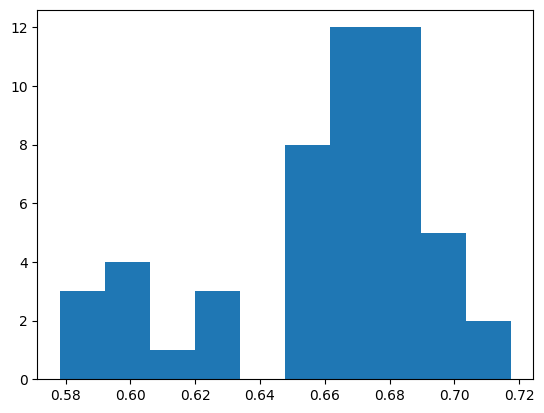

In [7]:
plt.hist(scores)

### Potential explanation: 
When sampling to generate pseudo trials, neurons are being sampled individually, which could lead to inflation of accuracies
To illustrate this, consider a simplified dataset with 2 neurons, 10 trials, with alternating labels per trial:

In [2]:
# 4 trials, label y alternates
trials = np.arange(4)
y = trials % 2
df = pd.DataFrame({"y": y, "x1": trials, "x2": trials})

In [3]:
df

,y,x1,x2
0,0,0,0
1,1,1,1
2,0,2,2
3,1,3,3


If we preserve covariance between x1, x2 there is no good linear separation for y

<Axes: xlabel='x1', ylabel='x2'>

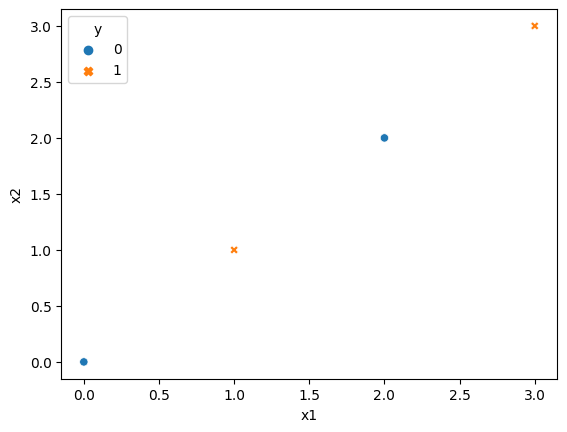

In [4]:
sns.scatterplot(df, x="x1", y="x2", style="y", hue="y")


In [5]:
score = LogisticRegression().fit(df[["x1", "x2"]], df["y"]).score(df[["x1", "x2"]], df["y"])
print(f"Logistic regression acc pre-sampling: {score}")

Logistic regression acc pre-sampling: 0.5


In [6]:
pos = df[df.y == 1]
cross_pos = pd.merge(pos[["y", "x1"]], pos[["x2"]], how="cross")

neg = df[df.y == 0]
cross_neg = pd.merge(neg[["y", "x1"]], neg[["x2"]], how="cross")

crossed = pd.concat((cross_pos, cross_neg))

<Axes: xlabel='x1', ylabel='x2'>

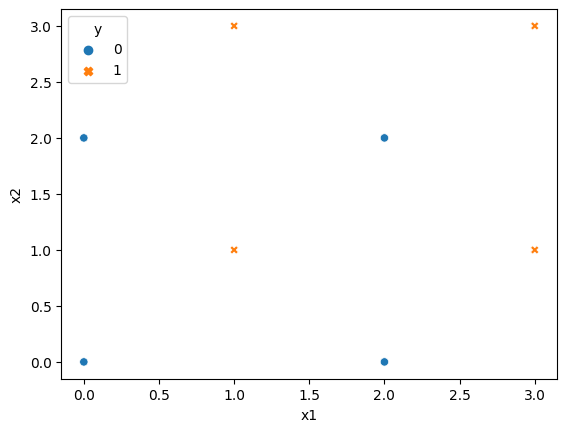

In [7]:
sns.scatterplot(crossed, x="x1", y="x2", style="y", hue="y")


In [8]:
score = LogisticRegression().fit(crossed[["x1", "x2"]], crossed["y"]).score(crossed[["x1", "x2"]], crossed["y"])
print(f"Logistic regression acc post-sampling: {score}")

Logistic regression acc post-sampling: 0.75


### Does this accuracy get higher with more neurons?

In [9]:
import itertools
n_trials = 4
n_units = 15
trials = np.arange(n_trials)
y = trials % 2
df = pd.DataFrame({"y": y, "trials": trials})

In [10]:
df

,y,trials
0,0,0
1,1,1
2,0,2
3,1,3


In [11]:
score = LogisticRegression().fit(df[["trials"]], df["y"]).score(df[["trials"]], df["y"])
print(f"Logistic regression acc pre-sampling: {score}")

Logistic regression acc pre-sampling: 0.5


In [12]:
pos_trials = df[df.y == 1].trials
pos_act = list(itertools.combinations_with_replacement(pos_trials, n_units))
pos_df = pd.DataFrame(pos_act, columns=[f"x{i}" for i in range(n_units)])
pos_df["y"] = 1

neg_trials = df[df.y == 0].trials
neg_act = list(itertools.combinations_with_replacement(neg_trials, n_units))
neg_df = pd.DataFrame(neg_act, columns=[f"x{i}" for i in range(n_units)])
neg_df["y"] = 0

comb_df = pd.concat((pos_df, neg_df))


In [13]:
lr = LogisticRegression()
xs = comb_df[[f"x{i}" for i in range(n_units)]]
ys = comb_df["y"]
score = lr.fit(xs, ys).score(xs, ys)
print(f"Logistic regression acc post-sampling: {score}")

Logistic regression acc post-sampling: 0.9375


### Iterate through num units
If I fixed the number of trials, and just increased the number of units (all still just trial number), how does that change decoding accuracy

In [14]:
accs = []
for n_units in range(1, 20):
    pos_trials = df[df.y == 1].trials
    pos_act = list(itertools.combinations_with_replacement(pos_trials, n_units))
    pos_df = pd.DataFrame(pos_act, columns=[f"x{i}" for i in range(n_units)])
    pos_df["y"] = 1

    neg_trials = df[df.y == 0].trials
    neg_act = list(itertools.combinations_with_replacement(neg_trials, n_units))
    neg_df = pd.DataFrame(neg_act, columns=[f"x{i}" for i in range(n_units)])
    neg_df["y"] = 0

    comb_df = pd.concat((pos_df, neg_df))

    lr = LogisticRegression()
    xs = comb_df[[f"x{i}" for i in range(n_units)]]
    ys = comb_df["y"]
    score = lr.fit(xs, ys).score(xs, ys)
    accs.append(score)


Text(0, 0.5, 'acc')

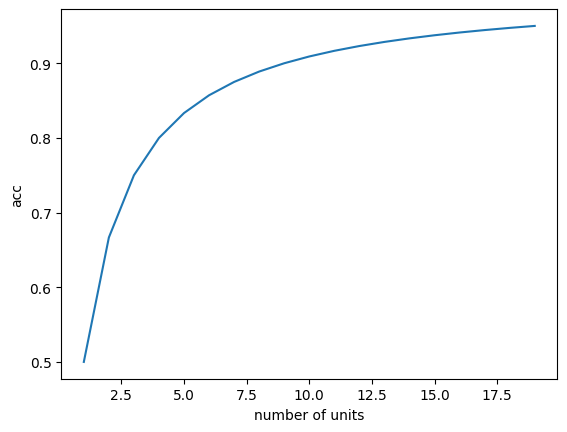

In [15]:
fig, ax = plt.subplots()
ax.plot(range(1, 20), accs)
ax.set_xlabel("number of units")
ax.set_ylabel("acc")

### Now verify this is true in the data
prediction: as we include more units to decode, the accuracy gets higher

In [27]:
unit_ids = trial_num_frs.UnitID.unique()
all_res = []
for n_units in range(1, len(unit_ids) + 1):
    print(f"num units {n_units}")
    sub_unit_ids = unit_ids[:n_units]
    sub_frs = trial_num_frs[trial_num_frs.UnitID.isin(sub_unit_ids)]
    session_data = SessionData(session, pref_beh, sub_frs, splitter)
    splits = session_data.pre_generate_splits(8)
    sess_datas = pd.Series([session_data])

    classes = ["TRIANGLE", "other"]
    num_neurons = sess_datas.apply(lambda x: x.get_num_neurons()).sum()
    init_params = {"n_inputs": num_neurons, "p_dropout": 0.5, "n_classes": len(classes)}
    # create a trainer object
    trainer = Trainer(learning_rate=0.05, max_iter=500, batch_size=1000)
    # create a wrapper for the decoder
    model = ModelWrapper(NormedDropoutMultinomialLogisticRegressor, init_params, trainer, classes)

    # time_bins = np.arange(0, (post_interval + pre_interval) / 1000, interval_size / 1000)
    time_bins = [0]
    _, test_accs, _, _ = pseudo_classifier_utils.evaluate_classifiers_by_time_bins(
        model, sess_datas, time_bins, NUM_SPLITS, NUM_TRAIN_PER_COND, NUM_TEST_PER_COND
    )
    res = pd.DataFrame({"n_units": n_units, "test_acc": test_accs.reshape(-1)})
    all_res.append(res)
all_res = pd.concat(all_res)
    


num units 1
cuda
Working on bin 0
Fitting model
Fitting model
Fitting model
Fitting model
Fitting model
Fitting model
Fitting model
Fitting model
num units 2
cuda
Working on bin 0
Fitting model
Fitting model
Fitting model
Fitting model
Fitting model
Fitting model
Fitting model
Fitting model
num units 3
cuda
Working on bin 0
Fitting model
Fitting model
Fitting model
Fitting model
Fitting model
Fitting model
Fitting model
Fitting model
num units 4
cuda
Working on bin 0
Fitting model
Fitting model
Fitting model
Fitting model
Fitting model
Fitting model
Fitting model
Fitting model
num units 5
cuda
Working on bin 0
Fitting model
Fitting model
Fitting model
Fitting model
Fitting model
Fitting model
Fitting model
Fitting model
num units 6
cuda
Working on bin 0
Fitting model
Fitting model
Fitting model
Fitting model
Fitting model
Fitting model
Fitting model
Fitting model
num units 7
cuda
Working on bin 0
Fitting model
Fitting model
Fitting model
Fitting model
Fitting model
Fitting model
Fittin

<Axes: xlabel='n_units', ylabel='test_acc'>

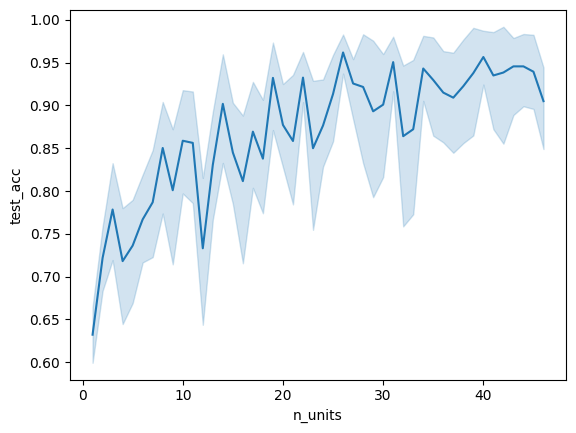

In [30]:
sns.lineplot(all_res, x="n_units", y="test_acc")

### Conclusion: 
Sampling unit activity individually could exascerbate (a form of?) non-sense correlation. 